# Модель машинного обучения для предсказания судьбы стартапов

## Описание задачи

Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.

## Установка библиотек

In [1]:
!pip install optuna
!pip install optuna-integration[sklearn]
!pip install shap
!pip install phik

## Подключение библиотек

In [2]:
from datetime import date

import numpy as np
import pandas as pd

import phik

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from optuna.integration import OptunaSearchCV

from optuna import distributions

## Загрузка данных

In [3]:
directory_name = '/Users/vault/Documents/YandexStartup'

train_data = pd.read_csv(f'{directory_name}/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [4]:
test_data = pd.read_csv(f'{directory_name}/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


## Предобработка данных

Необходимо все даты привести к типу дата, а также заполнить пропуски в столбце funding_total_usd 

In [5]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])
    df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])
    df['funding_total_usd'] = df['funding_total_usd'].fillna(0)
    if not 'lifetime' in df.columns:
        df['closed_at'] = df['closed_at'].fillna(value=date(2018, 1, 1))
        df['closed_at'] = pd.to_datetime(df['closed_at'])
        df['founded_at'] = pd.to_datetime(df['founded_at'])
        df['lifetime'] = df['closed_at'].subtract(df['founded_at']).dt.days.astype(int)
    return df

In [6]:
train_data = data_preprocessing(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
 13  lifetime           52516 non-null  int32         
dtypes: dat

## Разработка новых признаков

Было принято решение выделить следующие новые признаки: 
1) год основания
2) год первого раунда
3) год последнего раунда
4) средний размер инвестиций за раунд
5) главная категория

In [7]:
def calc_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
    df['first_funding_at_year'] = df['first_funding_at'].dt.year
    df['last_funding_at_year'] = df['last_funding_at'].dt.year
    df['main_category'] = df['category_list'].str.replace(' ', '').str.split('|').str[0]
    return df

In [8]:
train_data = calc_new_features(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          50051 non-null  object        
 2   funding_total_usd      52516 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  l

In [9]:
train_data.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_per_round,first_funding_at_year,last_funding_at_year
count,5.251600e+04,52516.000000,52516,52516,52516,52516,52516.000000,5.251600e+04,52516.000000,52516.000000
mean,1.474885e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2017-06-11 05:36:46.504684032,3140.828129,7.205211e+06,2011.075691,2012.012491
min,0.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00,19.000000,0.000000e+00,1977.000000,1977.000000
25%,4.000000e+04,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2018-01-01 00:00:00,1739.000000,4.000000e+04,2009.000000,2011.000000
50%,1.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2018-01-01 00:00:00,2557.000000,6.500000e+05,2012.000000,2013.000000
75%,6.788929e+06,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2018-01-01 00:00:00,4018.000000,4.000000e+06,2014.000000,2014.000000
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2018-01-01 00:00:00,17378.000000,1.066494e+10,2015.000000,2015.000000
std,1.683783e+08,1.374522,NaN,NaN,NaN,NaN,2147.821070,7.642925e+07,3.613547,3.336599


In [10]:
train_data.drop(
    ['first_funding_at', 'last_funding_at', 'closed_at', 'founded_at', 'name', 'category_list'], axis=1
).phik_matrix(
    interval_cols=['funding_total_usd', 'funding_per_round', 'lifetime']
)

C:\Users\vault\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4477. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
C:\Users\vault\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,funding_per_round,first_funding_at_year,last_funding_at_year,main_category
funding_total_usd,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.324087,0.103176,0.819290,0.108575,0.055955,0.000000
status,0.000000,1.000000,0.124833,0.114905,0.131156,0.039585,0.100557,0.535217,0.000000,0.205714,0.258342,0.159507
country_code,0.000000,0.124833,1.000000,0.993440,1.000000,0.999994,0.000000,0.190580,0.000000,0.130868,0.049224,0.702137
state_code,0.000000,0.114905,0.993440,1.000000,0.999927,0.999991,0.000000,0.254898,0.000000,0.000000,0.000000,0.661142
region,0.000000,0.131156,1.000000,0.999927,1.000000,1.000000,0.000000,0.351176,0.181669,0.000000,0.000000,0.797242
city,0.000000,0.039585,0.999994,0.999991,1.000000,1.000000,0.000000,0.646064,0.000000,0.574932,0.663172,0.860708
funding_rounds,0.324087,0.100557,0.000000,0.000000,0.000000,0.000000,1.000000,0.227475,0.000000,0.297841,0.162759,0.000000
lifetime,0.103176,0.535217,0.190580,0.254898,0.351176,0.646064,0.227475,1.000000,0.067375,0.688386,0.583075,0.370182
funding_per_round,0.819290,0.000000,0.000000,0.000000,0.181669,0.000000,0.000000,0.067375,1.000000,0.170109,0.060221,0.135750
first_funding_at_year,0.108575,0.205714,0.130868,0.000000,0.000000,0.574932,0.297841,0.688386,0.170109,1.000000,0.998388,0.439407


C:\Users\vault\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'funding_total_usd'}, xlabel='funding_total_usd', ylabel='Count'>

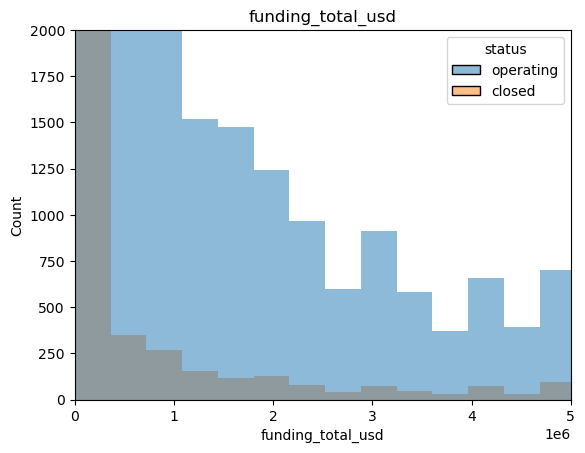

C:\Users\vault\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'funding_per_round'}, xlabel='funding_per_round', ylabel='Count'>

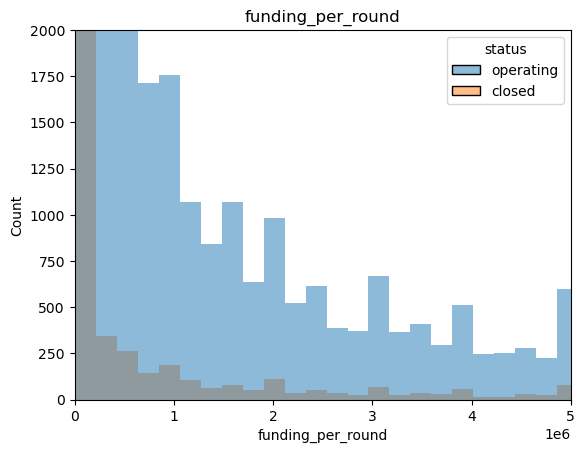

In [11]:
num_columns = ['funding_total_usd', 'funding_per_round']

for column in num_columns:
    plt.title(column)
    display(
        sns.histplot(
            x=train_data[column],
            hue=train_data['status'],
        )
    )
    plt.ylim(0, 2000)
    plt.xlim(0, 5000000)
    plt.show()

## Формирование пайплайнов

In [12]:
ord_columns = ['main_category', 'region']
num_columns = ['lifetime', 'funding_per_round']

data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_columns),
])

In [13]:
RANDOM_STATE = 42

pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 111),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf', 'precomputed'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__loss': ['log_loss', 'exponential'],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__criterion': ['friedman_mse', 'squared_error'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

In [14]:
classifier = RandomizedSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

## Подготовка данных для обучения модели

In [15]:
X_columns = [
    'main_category',
    'funding_per_round',
    'first_funding_at_year',
    'last_funding_at_year',
    'region', 'lifetime'
]
y_column = 'status'

In [16]:
train_data = train_data[X_columns + [y_column]].drop_duplicates()
X = train_data[X_columns]

In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data[y_column])
y

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
classifier.fit(X, y)

print(f'Лучшая модель и ее параметры: {classifier.best_estimator_}')
print(f'f1 лучшей модели на кросс-валидации: {classifier.best_score_}')

Лучшая модель и ее параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['lifetime',
                                                   'funding_per_round'])])),
                ('models',
                 GradientBoostingClassifier(loss='exponential', max_depth=5,
                                            min_samples_leaf=4,
                                            min_samples_split=3,
                                            random_state=42))])
f1 лучшей модели на кросс-валидации: 0.9738439961349948


## Тестирование модели

In [19]:
test_data = data_preprocessing(test_data)
test_data = calc_new_features(test_data)
y_predict = classifier.predict(test_data)
y_predict

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
encoded_labels = label_encoder.inverse_transform(y_predict)
result = pd.DataFrame({
    'name': test_data['name'],
    'status': encoded_labels
})
result.set_index('name', inplace=True)
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   status  13125 non-null  object
dtypes: object(1)
memory usage: 205.1+ KB


In [21]:
result.to_csv('solobuto_kaggle_startups.csv')

## V2

In [22]:
param_grid = {
    'models__loss': distributions.CategoricalDistribution(('log_loss', 'exponential')),
    'models__max_depth': distributions.IntDistribution(2, 10),
    'models__min_samples_split': distributions.IntDistribution(2, 10),
    'models__min_samples_leaf': distributions.IntDistribution(2, 10),
    'models__criterion': distributions.CategoricalDistribution(('friedman_mse', 'squared_error')),
    'preprocessor__num': distributions.CategoricalDistribution((StandardScaler(), MinMaxScaler(), 'passthrough')),
}

C:\Users\vault\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
C:\Users\vault\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)


In [23]:
optuna_classifier = OptunaSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_trials=20,
)

C:\Users\vault\AppData\Local\Temp\ipykernel_24556\1378919119.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_classifier = OptunaSearchCV(


In [24]:
optuna_classifier.fit(X, y)

print(f'Лучшая модель и ее параметры: {optuna_classifier.best_estimator_}')
print(f'f1 лучшей модели на кросс-валидации: {optuna_classifier.best_score_}')

[I 2024-12-22 13:58:47,998] A new study created in memory with name: no-name-73651945-ec92-4d64-b4d9-0f7162c86d3e
[I 2024-12-22 13:59:11,480] Trial 0 finished with value: 0.9729548306277938 and parameters: {'models__loss': 'log_loss', 'models__max_depth': 2, 'models__min_samples_split': 2, 'models__min_samples_leaf': 10, 'models__criterion': 'friedman_mse', 'preprocessor__num': 'passthrough'}. Best is trial 0 with value: 0.9729548306277938.
[I 2024-12-22 13:59:20,796] Trial 1 finished with value: 0.9735183803580167 and parameters: {'models__loss': 'log_loss', 'models__max_depth': 3, 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__criterion': 'squared_error', 'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: 0.9735183803580167.
[I 2024-12-22 13:59:23,069] Trial 2 finished with value: 0.97310352792051 and parameters: {'models__loss': 'exponential', 'models__max_depth': 3, 'models__min_samples_split': 3, 'models__min_samples_leaf': 9, 'models__crite

Лучшая модель и ее параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lifetime',
                                                   'funding_per_round'])])),
                ('models',
                 GradientBoostingClassifier(criterion='squared_error',
                                            loss='exponential', max_depth=6,
                                            min_samples_leaf=9,
                                            min_samples_split=9,
                                            random_state=42))])
f1 лучшей модели на кросс-валидации: 0.9739351197754289


In [25]:
y_predict = optuna_classifier.predict(test_data)
y_predict

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
encoded_labels = label_encoder.inverse_transform(y_predict)
result = pd.DataFrame({
    'name': test_data['name'],
    'status': encoded_labels
})
result.set_index('name', inplace=True)
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   status  13125 non-null  object
dtypes: object(1)
memory usage: 205.1+ KB


In [27]:
result.to_csv('solobuto_kaggle_startups.csv')